In [279]:
# AUTHOR Christian Dansereau 2016

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import scipy.io
import nibabel as nib
from nibabel.affines import apply_affine

# Load data

In [280]:
seed_data = pd.read_csv('20160128_AD_Decrease_Meta_Christian.csv')
template_020= nib.load('/home/cdansereau/data/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale020.nii.gz')
template_012= nib.load('/home/cdansereau/data/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale012.nii.gz')
template_007= nib.load('/home/cdansereau/data/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale007.nii.gz')

template = template_007

## Get the number of coordinates reported for each network

In [281]:
# Convert from world MNI space to the EPI voxel space
def get_world2vox(template, mni_coord):
    return np.round(apply_affine(npl.inv(template.get_affine()),mni_coord)+[1])
    
network_votes = np.zeros((np.max(template.get_data().flatten()),1))[:,0]
network_votes

# get the voxel coordinates of the MNI seeds
vox_corrd = get_world2vox(template,seed_data[['x','y','z']].values)
votes = []
for i in range(vox_corrd.shape[0]):
    votes.append(template.get_data()[vox_corrd[i,0],vox_corrd[i,1],vox_corrd[i,2]])
votes = np.array(votes)    

for i in range(1,len(network_votes)+1):
    network_votes[i-1] = np.sum(votes==i)

print network_votes 
#vox_corrd[np.array(votes)==5,:]

[  0.   3.   4.   9.  17.  10.   8.]


## Generate random coordinates
#### The assigned coodinates are generated for each network witha proability equivalent to there volume size compare to the total volume of the brain

In [282]:

# Total volume of the brain
total_volume = np.sum(template.get_data()>0)

# compute the proba of each network
proba_networks=[]
for i in range(1,len(network_votes)+1):
    proba_networks.append(np.sum(template.get_data()==i)/(total_volume*1.))
proba_networks = np.array(proba_networks)
print np.sum(proba_networks)
print proba_networks

# generate random values 
def gen_rnd_hits(proba,n_seeds):
    results_h0 =  np.random.choice(range(0,len(proba)),size=(n_seeds,1000),p=proba)
    ditributions = []
    for i in range(len(proba)):
        one_way_pdf = np.sort(np.sum(results_h0 == i,axis=0))
        ditributions.append(one_way_pdf[::-1])   
    return ditributions
    
dist_data = gen_rnd_hits(proba_networks,np.sum(network_votes[1:]))


1.0
[ 0.12507354  0.0961412   0.08271327  0.11642153  0.15549403  0.21121301
  0.21294342]


7


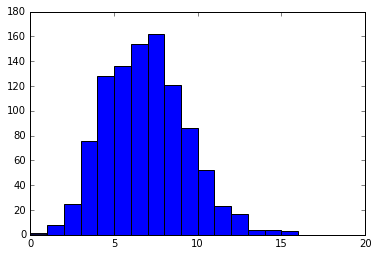

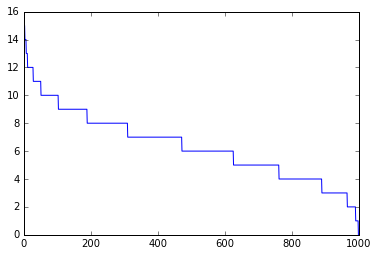

In [283]:
print len(dd)
plt.figure()
plt.hist(dist_data[0],bins=np.arange(0,20,1))
plt.figure()
plt.plot(dist_data[0].T)

## Generate the p-values for each network

[  3.   4.   9.  17.  10.   8.]
[1.0, 0.86513486513486515, 0.61838161838161843, 0.14085914085914086, 0.001998001998001998, 0.64535464535464537, 0.89710289710289715]


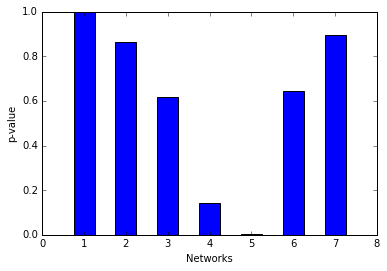

In [284]:
def getpval(nhit,dist_data):
    distribution_val =  np.histogram(dist_data,bins=np.arange(0,50,1))
    return (np.sum(distribution_val[0][nhit:-1])+1)/(dist_data.shape[0]+1.)

print network_votes[1:]

pval_results=[]
for i in range(0,len(dist_data)):
    pval_results.append(getpval(network_votes[i],dist_data[i]))
    
print pval_results
plt.figure()
plt.bar(np.arange(1,len(pval_results)+1),pval_results,width=0.5,align='center')
plt.xlabel('Networks')
plt.ylabel('p-value')

#### FDR correction of the p-values

In [285]:
# correct for FRD
from statsmodels.sandbox.stats.multicomp import fdrcorrection0

fdrcorrection0(pval_results,alpha=0.05)

(array([False, False, False, False,  True, False, False], dtype=bool),
 array([ 1.        ,  1.        ,  1.        ,  0.49300699,  0.01398601,
         1.        ,  1.        ]))